In [ ]:
!pip install stable-baselines==2.9.0

In [ ]:
import numpy as np

import datetime
import time
from collections import deque

import torch as T
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.distributions import Categorical
from torch.optim.lr_scheduler import LambdaLR
from torchsummary import summary

from stable_baselines.common.misc_util import set_global_seeds
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ENV_NAME = 'BreakoutNoFrameskip-v4'
NENV = 8
ROLLOUT_LENGTH = 128
LATENT_SIZE = 256
MB_SPLIT = 4
MB_EPOCHS = 4
TOTAL_TIMESTEPS = 5e6
GAMMA = 0.99
CLIP = 0.2
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')
SEED = 420 
set_global_seeds(SEED)
sns.set()  # make it pretty

# Environment

In [4]:
env = make_atari_env(ENV_NAME, num_env=NENV, seed=SEED)
env = VecFrameStack(env, n_stack=4)

in_dim = env.observation_space.shape
in_dim=(in_dim[2],in_dim[0],in_dim[1])  # torch ordering
num_actions = env.action_space.n

print('Observation shape: ', in_dim)
print('Number of actions: ', num_actions)

Observation shape:  (4, 84, 84)
Number of actions:  4


# CNNs

In [0]:
def conv_size(net, in_shape):
    """ util for calculating flat output shape of a given net """
    x = Variable(T.rand(1, *in_shape))
    o = net(x)
    b = (-1, o.size(1), o.size(2), o.size(3))
    return b, o.data.view(1, -1).size(1)

In [0]:
def ConvReLU_down(in_channels, out_channels, kernel, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, stride),
        nn.ReLU(inplace=True),
    )

def ConvReLU_up(in_channels, out_channels, kernel, stride):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel, stride),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    """ This is used to *represent* the environment (perception).
        The latent space of this autoencoder is uni-dimensional.
    """
    def __init__(self, input_shape, num_actions, latent_size):
        super().__init__()
        self.c, self.h, self.w = input_shape
        self.num_actions = num_actions
        self.latent_size = latent_size

        self.down_1 = ConvReLU_down(self.c, 64, 8, 4)
        self.down_2 = ConvReLU_down(64, 32, 4, 2)
        self.down_3 = ConvReLU_down(32, 16, 4, 1)

        encoder_conv = nn.Sequential(self.down_1, self.down_2, self.down_3)
        self.conv_x, self.conv_f = conv_size(encoder_conv, input_shape)

        self.down_linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.conv_f, self.latent_size)
        )

        self.up_linear = nn.Sequential(
            nn.Linear(self.latent_size, self.conv_f),
            nn.ReLU(True)
        )

        self.up_3 = ConvReLU_up(16*2+self.num_actions, 32, 4, 1)
        self.up_2 = ConvReLU_up(32*2, 64, 4, 2)
        self.up_1 = nn.ConvTranspose2d(64*2, self.c, 8, 4)

    def encode(self, x):
        """ *represent* the environment in latent space"""
        x = self.down_1(x)
        x = self.down_2(x)
        x = self.down_3(x)
        x = self.down_linear(x)
        return x  # latent code

    def one_hot_3d_action(self, actions):
        _,_,ch,cw = self.conv_x
        cn = len(actions)
        z = np.zeros((len(actions), self.num_actions, ch, cw), dtype=np.float32)
        for i in range(cn):
            z[i,actions[i],:,:] = 1.0
        z = T.from_numpy(z).to(DEVICE)
        return z

    def forward(self, x, actions=None):
        """ actions is a list of ints describing the actions taken """
        d1 = self.down_1(x)
        d2 = self.down_2(d1)
        d3 = self.down_3(d2)
        latent = self.down_linear(d3)
        
        x = self.up_linear(latent)        
        x = x.view(self.conv_x)
        # cat contractive path
        x = T.cat((x, d3), dim=1)
        # add information about which action we took
        if actions is None:  # for torchsummary
            z_action = self.one_hot_3d_action([0]*x.size(0))
        else:
            z_action = self.one_hot_3d_action(actions)
        x = T.cat((x, z_action), dim=1)

        x = self.up_3(x)
        x = T.cat((x, d2), dim=1)
        x = self.up_2(x)
        x = T.cat((x, d1), dim=1)
        x = self.up_1(x)

        return x, latent

In [0]:
class ACTOR(nn.Module):
    """ This is used to learn *behaviour* from our environment representation.
        ActorCriticCritic uses two value heads/critics. One criticises the 
        extrinsic reward. The other criticises the intrinsic reward.
    """
    def __init__(self, num_inputs, num_actions):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(num_inputs, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True)
        )

        self.actor = nn.Linear(512, num_actions)

    def forward(self, x):
        x = self.linear(x)
        return self.actor(x)

class CRITIC(nn.Module):
    """ This is used to learn *behaviour* from our environment representation.
        ActorCriticCritic uses two value heads/critics. One criticises the 
        extrinsic reward. The other criticises the intrinsic reward.
    """
    def __init__(self, num_inputs, num_actions):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(num_inputs, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True)
        )

        self.critic = nn.Linear(512, 1)

    def forward(self, x):
        x = self.linear(x)
        return self.critic(x)

# Rollout handling

In [0]:
class Rollouts:

    def __init__(self):
        self.empty_memory()

    def store_transition(self, ob, logp, action, reward, value, done, info):
        self.obs.append(ob)
        self.logps.append(logp)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.dones.append(done)
        for i in info:
            if i.get('episode'): 
                self.infos['l'].append(i['episode']['l'])
                self.infos['r'].append(i['episode']['r'])

    def empty_memory(self):
        self.obs      = []
        self.obs_d1   = []  # t+1
        self.obs_d2   = []  # t+2
        self.logps    = []
        self.actions  = []
        self.rewards  = []
        self.values   = []
        self.dones    = []
        self.infos   = {'l':[], 'r':[]}

    def preprocess_obs(self, arr):
        """ Normalize and permute array :param arr: to make it Torch compatible """
        return np.moveaxis(arr.astype(np.float32) / 255., -1, 1)

    def flatten(self, x, flat_n, to_tensor=True):
        """ flatten x *in place* to (flat_n, ...)
            :param to_tensor: if true, x is cast to a torch tenor """
        x = np.asarray(x, np.float32).reshape((flat_n,)+x[0].shape[1:])
        if to_tensor: 
            return T.from_numpy(x).to(DEVICE)
        return x

    def flatten_rollout(self):
        """ flatten trajectory buffers to (NENV*ROLLOUT_LENGTH-1, ...)"""
        N = (ROLLOUT_LENGTH-1)*NENV
        self.obs     = self.flatten(self.obs, N)
        self.obs_d1  = self.flatten(self.obs_d1, N)
        self.obs_d2  = self.flatten(self.obs_d2, N)
        self.logps   = self.flatten(self.logps, N)
        self.actions = self.flatten(self.actions, N)
        self.rewards = self.flatten(self.rewards, N)
        self.values  = self.flatten(self.values, N)


    def generator(self, random=False):

        ob = self.preprocess_obs(env.reset())  # initial observation
        rollout_num = 0

        while True:
            rollout_num += 1
            
            with T.no_grad():
                tob = T.from_numpy(ob).to(DEVICE)
                z1 = ae_delta_1.encode(tob)      # latent repr of St+1
                z2 = ae_delta_2.encode(tob)      # latent repr of St+2
                z_join = T.cat((z1,z2), dim=1)   # joint latent repr

                pi     = actor(z_join)           # action scores
                v      = critic(z_join)          # value
                dist   = Categorical(logits=pi)  # to multinomial (discreet)
                action = dist.sample()
                if random: action = T.randint_like(action, 0, num_actions)
                log_pi = dist.log_prob(action).cpu().numpy()
                action = action.cpu().numpy()
                v = v.cpu().numpy()[:, 0]
            
            new_ob, reward, done, info = env.step(action)
            self.store_transition(ob, log_pi, action, reward, v, done, info)
            ob = self.preprocess_obs(new_ob)

            if rollout_num % ROLLOUT_LENGTH == 0:
                # bootstrap reward from critic predicted value function
                # note that v is V(S_{t+1}) - TD(1) (one step returns)
                with T.no_grad():
                    tob = T.from_numpy(ob).to(DEVICE)
                    z1 = ae_delta_1.encode(tob)      # latent repr of St+1
                    z2 = ae_delta_2.encode(tob)      # latent repr of St+2
                    z_join = T.cat((z1,z2), dim=1)   # joint latent repr
                    flags = 1 - done   # should we bootstrap or not?
                    v = critic(z_join)  # value of next state TD(1)
                    v = v.cpu().numpy()[:, 0] * flags

                # reward discounting / creit assignment
                self.rewards[-1] += GAMMA * v
                for i in reversed(range(ROLLOUT_LENGTH - 1)):
                    flags = 1 - self.dones[i]
                    self.rewards[i] += GAMMA * self.rewards[i+1] * flags

                self.obs_d1 = self.obs[1:]         # for ae_delta_1
                self.obs_d2 = self.obs[2:] + [ob]  # for ae_delta_2
                del self.obs[-1]
                del self.logps[-1]
                del self.actions[-1]
                del self.values[-1]
                del self.rewards[-1]

                # reshape and cast to torch tensors (rollouts)
                self.flatten_rollout()
                yield self.obs, self.obs_d1, self.obs_d2, self.logps, self.actions, self.values, self.rewards, self.infos
                self.empty_memory()

# Train

In [9]:
# this autoencoder predicts S_{t+1}.
ae_delta_1 = UNet(in_dim, num_actions, LATENT_SIZE).to(DEVICE)
ae_optim_1 = Adam(ae_delta_1.parameters(), 7e-4, eps=1e-5)
T.save(ae_delta_1, 'clone.t')

# this autoencoder predicts S_{t+2}. 
# cloned so latent dynamics are similar.
ae_delta_2 = T.load('clone.t').to(DEVICE)
ae_optim_2 = Adam(ae_delta_2.parameters(), 7e-4, eps=1e-5)

# this is our actor + critic
# input is both latent vectors of above autoencoders.
actor = ACTOR(LATENT_SIZE*2, num_actions).to(DEVICE)
actor_optim = Adam(actor.parameters(), 7e-4, eps=1e-5)

critic = CRITIC(LATENT_SIZE*2, num_actions).to(DEVICE)
critic_optim = Adam(critic.parameters(), 7e-4, eps=1e-5)

summary(ae_delta_1, input_size=in_dim, batch_size=NENV*ROLLOUT_LENGTH)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [1024, 64, 20, 20]          16,448
              ReLU-2         [1024, 64, 20, 20]               0
            Conv2d-3           [1024, 32, 9, 9]          32,800
              ReLU-4           [1024, 32, 9, 9]               0
            Conv2d-5           [1024, 16, 6, 6]           8,208
              ReLU-6           [1024, 16, 6, 6]               0
           Flatten-7                [1024, 576]               0
            Linear-8                [1024, 256]         147,712
            Linear-9                [1024, 576]         148,032
             ReLU-10                [1024, 576]               0
  ConvTranspose2d-11           [1024, 32, 9, 9]          18,464
             ReLU-12           [1024, 32, 9, 9]               0
  ConvTranspose2d-13         [1024, 64, 20, 20]          65,600
             ReLU-14         [1024, 64,

In [0]:
NUM_UPDATES = 1000

MB_LEN      = int(NENV*(ROLLOUT_LENGTH-1))
SPLIT_LEN   = int(MB_LEN//MB_SPLIT)
NUM_UPDATES = int(TOTAL_TIMESTEPS//MB_LEN)

rgen = Rollouts().generator(random=True)

actor_scheduler  = LambdaLR(actor_optim, lambda i: 1 - (i / NUM_UPDATES))
critic_scheduler  = LambdaLR(critic_optim, lambda i: 1 - (i / NUM_UPDATES))
ae_1_scheduler = LambdaLR(ae_optim_1, lambda i: 1 - (i / NUM_UPDATES))
ae_2_scheduler = LambdaLR(ae_optim_2, lambda i: 1 - (i / NUM_UPDATES))

Batch 0, loss_ae_1 0.0037882837932556868, loss_ae_2 0.004743948578834534
OBS:


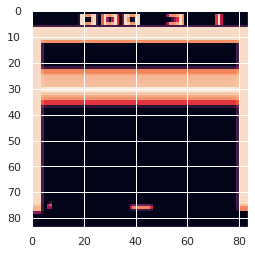

TARGET D1:


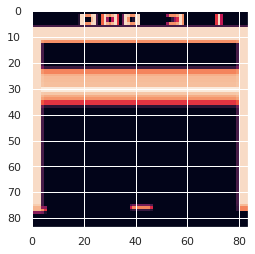

PRED D1:


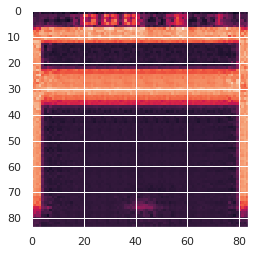

TARGET D2:


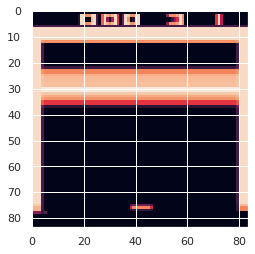

PRED D2:


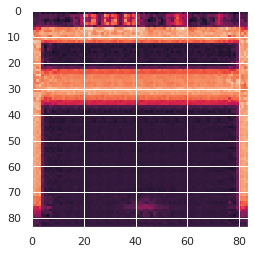

Batch 1, loss_ae_1 0.002924589440226555, loss_ae_2 0.004055984318256378
Batch 2, loss_ae_1 0.0023581068962812424, loss_ae_2 0.00330183538608253
Batch 3, loss_ae_1 0.0022665616124868393, loss_ae_2 0.0033248679246753454
Batch 4, loss_ae_1 0.0018336566863581538, loss_ae_2 0.002777927787974477
Batch 5, loss_ae_1 0.002005895134061575, loss_ae_2 0.003185086650773883
OBS:


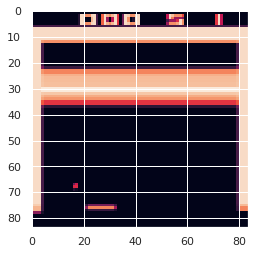

TARGET D1:


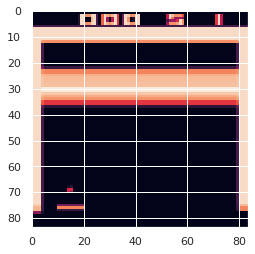

PRED D1:


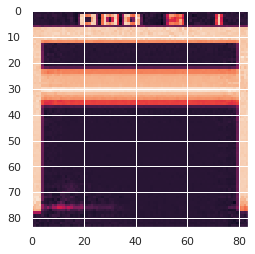

TARGET D2:


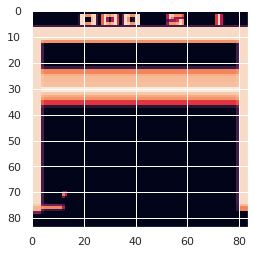

PRED D2:


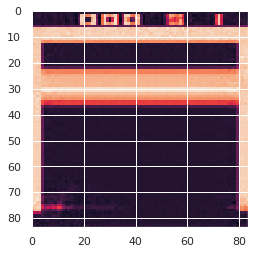

Batch 6, loss_ae_1 0.0013885091757401824, loss_ae_2 0.0020776023156940937
Batch 7, loss_ae_1 0.002186463214457035, loss_ae_2 0.0033368412405252457
Batch 8, loss_ae_1 0.0017405726248398423, loss_ae_2 0.0026756254956126213
Batch 9, loss_ae_1 0.002122432691976428, loss_ae_2 0.0032801837660372257
Batch 10, loss_ae_1 0.0016839558957144618, loss_ae_2 0.0026794737204909325
OBS:


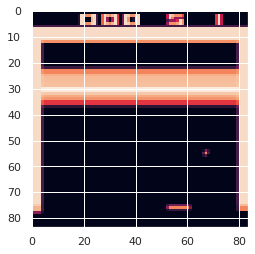

TARGET D1:


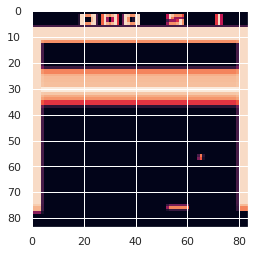

PRED D1:


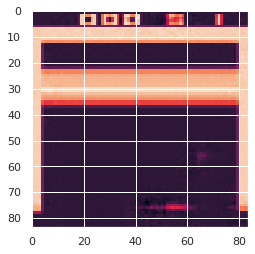

TARGET D2:


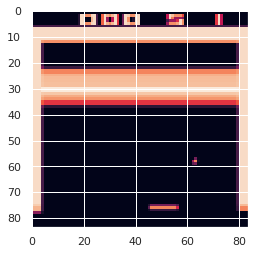

PRED D2:


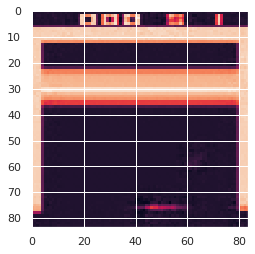

Batch 11, loss_ae_1 0.0022465328220278025, loss_ae_2 0.0034505599178373814
Batch 12, loss_ae_1 0.001667229225859046, loss_ae_2 0.0026166304014623165
Batch 13, loss_ae_1 0.0018363657873123884, loss_ae_2 0.0028872049879282713
Batch 14, loss_ae_1 0.002332353498786688, loss_ae_2 0.0036640753969550133
Batch 15, loss_ae_1 0.0019305521855130792, loss_ae_2 0.0030582277104258537
OBS:


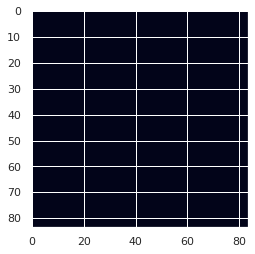

TARGET D1:


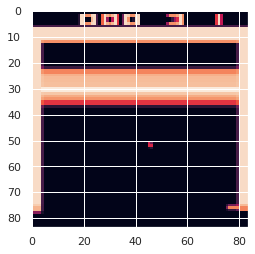

PRED D1:


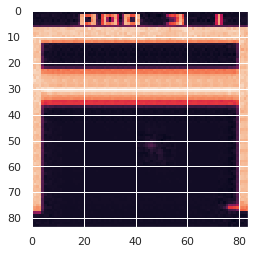

TARGET D2:


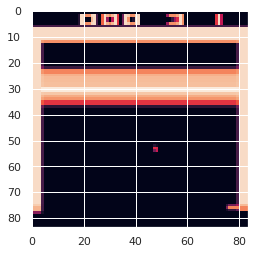

PRED D2:


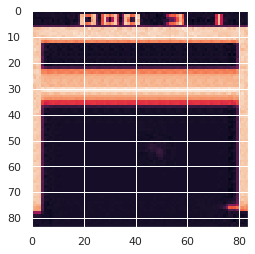

Batch 16, loss_ae_1 0.002095117699354887, loss_ae_2 0.0032614553347229958
Batch 17, loss_ae_1 0.0025234073400497437, loss_ae_2 0.004034847021102905
Batch 18, loss_ae_1 0.002021900610998273, loss_ae_2 0.003214898519217968
Batch 19, loss_ae_1 0.0016746596666052938, loss_ae_2 0.0026733758859336376
Batch 20, loss_ae_1 0.0015665390528738499, loss_ae_2 0.002610214287415147
OBS:


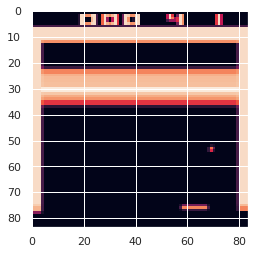

TARGET D1:


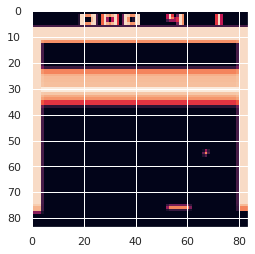

PRED D1:


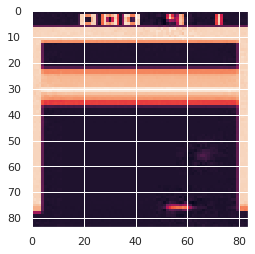

TARGET D2:


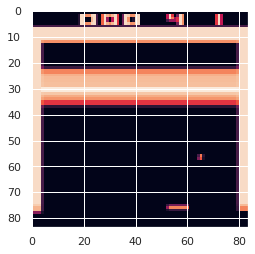

PRED D2:


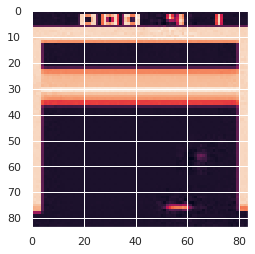

Batch 21, loss_ae_1 0.0019039434846490622, loss_ae_2 0.003027701750397682
Batch 22, loss_ae_1 0.0020601556170731783, loss_ae_2 0.0032858909107744694
Batch 23, loss_ae_1 0.0017808767734095454, loss_ae_2 0.0027927160263061523
Batch 24, loss_ae_1 0.0021166307851672173, loss_ae_2 0.0033694992307573557
Batch 25, loss_ae_1 0.0018937247805297375, loss_ae_2 0.003036184934899211
OBS:


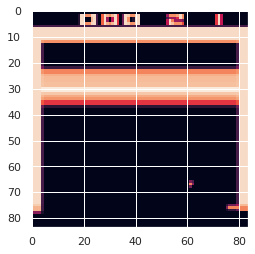

TARGET D1:


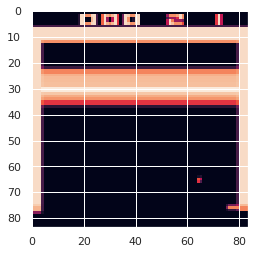

PRED D1:


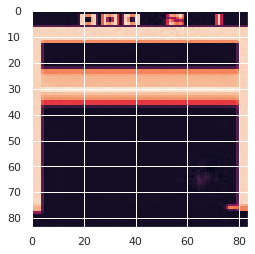

TARGET D2:


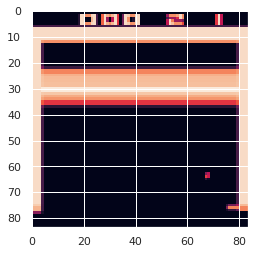

PRED D2:


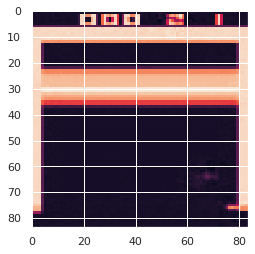

Batch 26, loss_ae_1 0.0021637880709022284, loss_ae_2 0.003399319015443325
Batch 27, loss_ae_1 0.0018094562692567706, loss_ae_2 0.0029050318989902735
Batch 28, loss_ae_1 0.0015839620027691126, loss_ae_2 0.002546010073274374
Batch 29, loss_ae_1 0.002102053025737405, loss_ae_2 0.003363339463248849
Batch 30, loss_ae_1 0.002378282602876425, loss_ae_2 0.0036845123395323753
OBS:


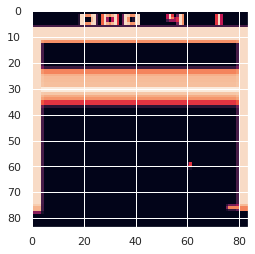

TARGET D1:


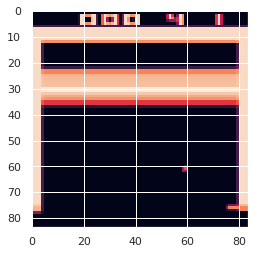

PRED D1:


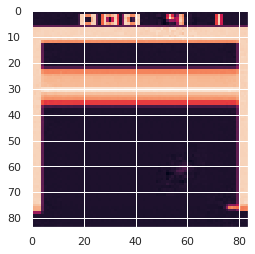

TARGET D2:


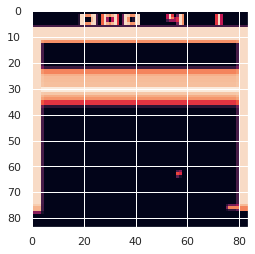

PRED D2:


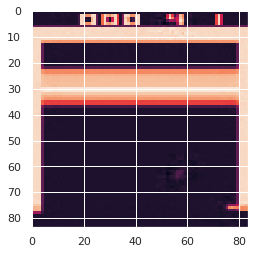

Batch 31, loss_ae_1 0.0021665499079972506, loss_ae_2 0.003470857860520482
Batch 32, loss_ae_1 0.001923064817674458, loss_ae_2 0.0030385232530534267
Batch 33, loss_ae_1 0.0018714094767346978, loss_ae_2 0.0029579869005829096
Batch 34, loss_ae_1 0.0022066691890358925, loss_ae_2 0.003585865255445242
Batch 35, loss_ae_1 0.00175467471126467, loss_ae_2 0.0028289116453379393
OBS:


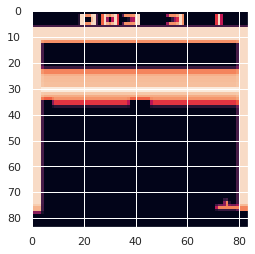

TARGET D1:


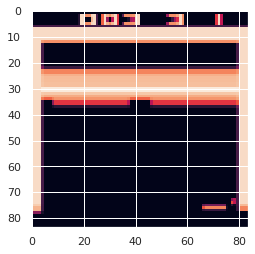

PRED D1:


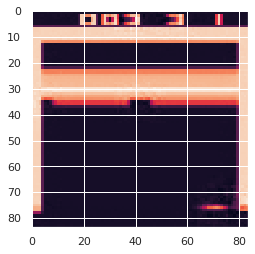

TARGET D2:


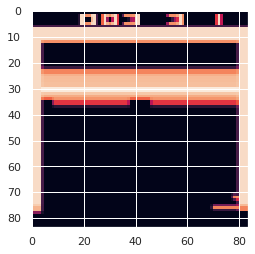

PRED D2:


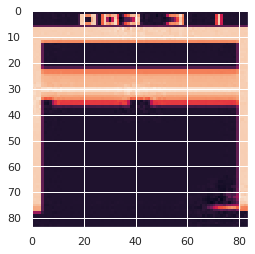

Batch 36, loss_ae_1 0.002082505961880088, loss_ae_2 0.003281728830188513
Batch 37, loss_ae_1 0.002373737283051014, loss_ae_2 0.00384197267703712
Batch 38, loss_ae_1 0.0019775680266320705, loss_ae_2 0.003236405085772276
Batch 39, loss_ae_1 0.0020729240495711565, loss_ae_2 0.003321872791275382
Batch 40, loss_ae_1 0.002030148869380355, loss_ae_2 0.0032656597904860973
OBS:


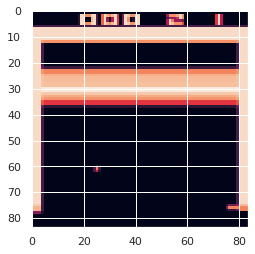

TARGET D1:


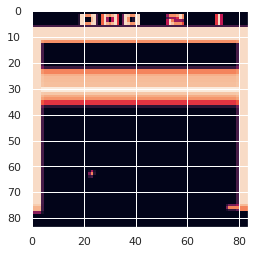

PRED D1:


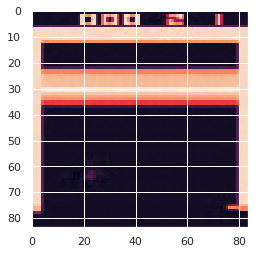

TARGET D2:


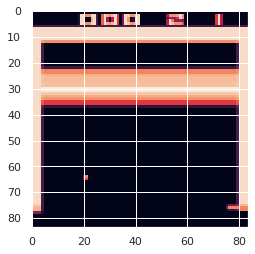

PRED D2:


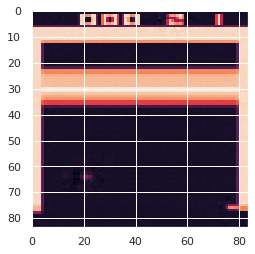

Batch 41, loss_ae_1 0.001977663952857256, loss_ae_2 0.0031785371247678995
Batch 42, loss_ae_1 0.0018565320642665029, loss_ae_2 0.0030440364498645067
Batch 43, loss_ae_1 0.0013424087082967162, loss_ae_2 0.00223752879537642
Batch 44, loss_ae_1 0.0018010399071499705, loss_ae_2 0.0028993019368499517
Batch 45, loss_ae_1 0.002140179742127657, loss_ae_2 0.003438106970861554
OBS:


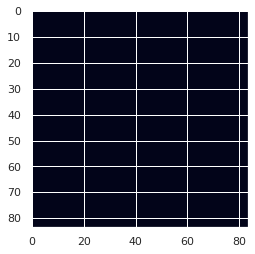

TARGET D1:


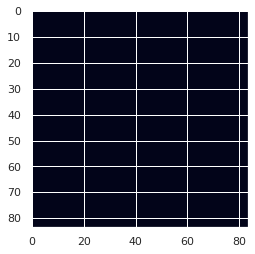

PRED D1:


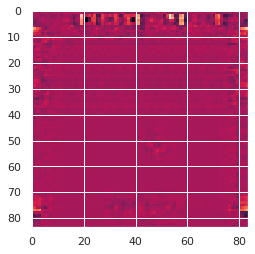

TARGET D2:


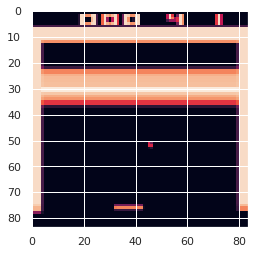

PRED D2:


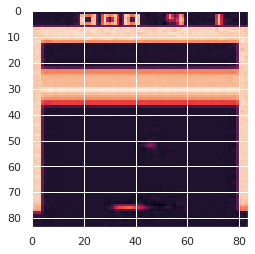

Batch 46, loss_ae_1 0.0015693326713517308, loss_ae_2 0.002542914589866996
Batch 47, loss_ae_1 0.002033384284004569, loss_ae_2 0.0032691287342458963
Batch 48, loss_ae_1 0.0020868757274001837, loss_ae_2 0.0033575554843991995
Batch 49, loss_ae_1 0.001961599802598357, loss_ae_2 0.0031659642700105906
Batch 50, loss_ae_1 0.0019651763141155243, loss_ae_2 0.0031135287135839462
OBS:


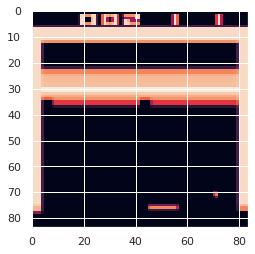

TARGET D1:


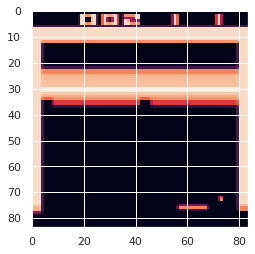

PRED D1:


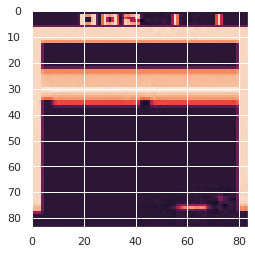

TARGET D2:


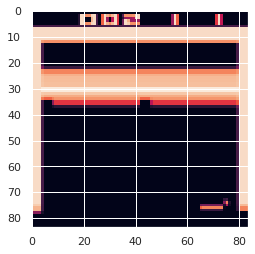

PRED D2:


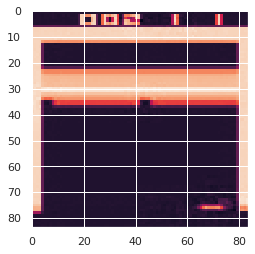

Batch 51, loss_ae_1 0.0020717449951916933, loss_ae_2 0.0033342824317514896
Batch 52, loss_ae_1 0.0020262545440346003, loss_ae_2 0.0031979787163436413
Batch 53, loss_ae_1 0.0018982323817908764, loss_ae_2 0.00306787621229887
Batch 54, loss_ae_1 0.0023409402929246426, loss_ae_2 0.003754237899556756
Batch 55, loss_ae_1 0.0018504556501284242, loss_ae_2 0.0029413162264972925
OBS:


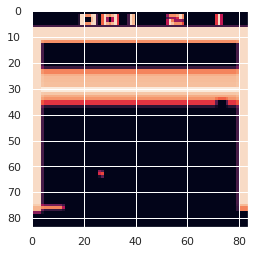

TARGET D1:


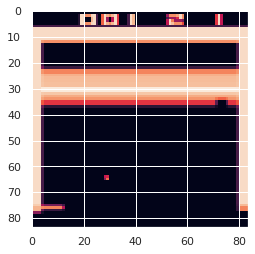

PRED D1:


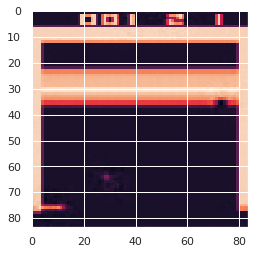

TARGET D2:


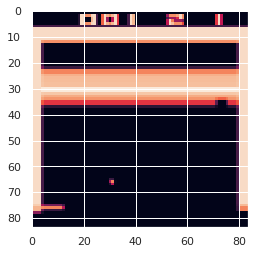

PRED D2:


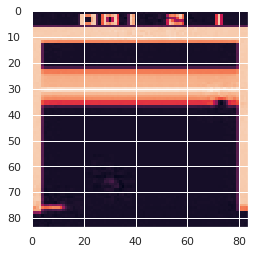

Batch 56, loss_ae_1 0.001451466465368867, loss_ae_2 0.002356946934014559
Batch 57, loss_ae_1 0.002082763472571969, loss_ae_2 0.0033012640196830034
Batch 58, loss_ae_1 0.00196500844322145, loss_ae_2 0.003111300291493535
Batch 59, loss_ae_1 0.0017898572841659188, loss_ae_2 0.0028403797186911106
Batch 60, loss_ae_1 0.0018471975345164537, loss_ae_2 0.0029818019829690456
OBS:


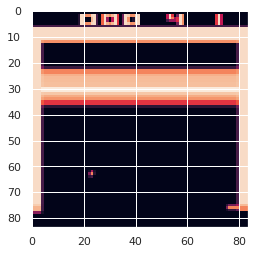

TARGET D1:


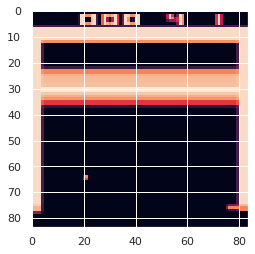

PRED D1:


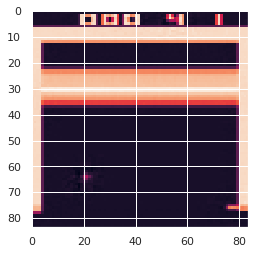

TARGET D2:


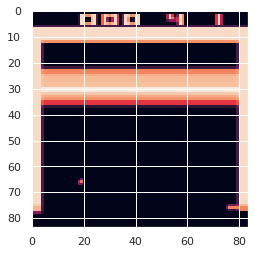

PRED D2:


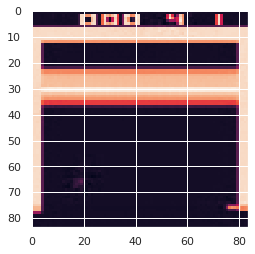

Batch 61, loss_ae_1 0.001789698377251625, loss_ae_2 0.002892776159569621
Batch 62, loss_ae_1 0.0016712485812604427, loss_ae_2 0.0026571862399578094
Batch 63, loss_ae_1 0.0020629498176276684, loss_ae_2 0.0033235950395464897
Batch 64, loss_ae_1 0.0017187302000820637, loss_ae_2 0.0027291085571050644
Batch 65, loss_ae_1 0.0018484694883227348, loss_ae_2 0.0030407679732888937
OBS:


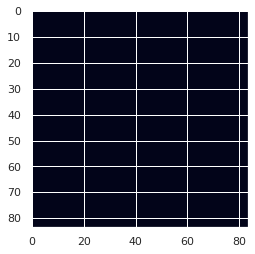

TARGET D1:


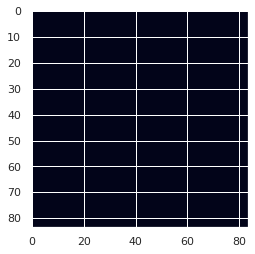

PRED D1:


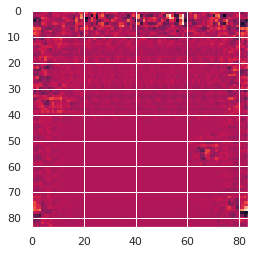

TARGET D2:


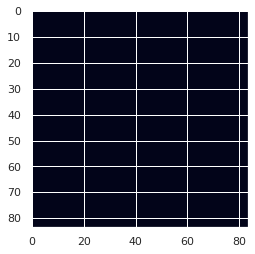

PRED D2:


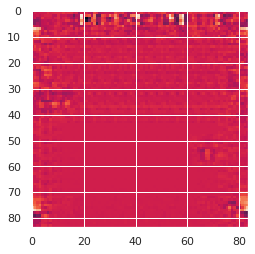

Batch 66, loss_ae_1 0.0019574612379074097, loss_ae_2 0.0031604107934981585
Batch 67, loss_ae_1 0.0019508639816194773, loss_ae_2 0.0032038434874266386
Batch 68, loss_ae_1 0.0017247627256438136, loss_ae_2 0.0028496345039457083
Batch 69, loss_ae_1 0.0018447008915245533, loss_ae_2 0.0029777574818581343
Batch 70, loss_ae_1 0.0016038431786000729, loss_ae_2 0.002605505520477891
OBS:


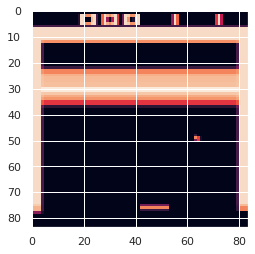

TARGET D1:


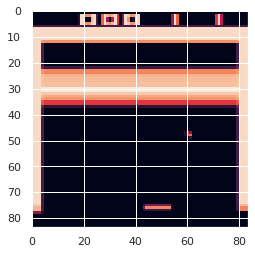

PRED D1:


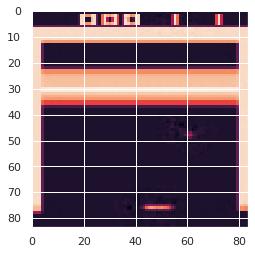

TARGET D2:


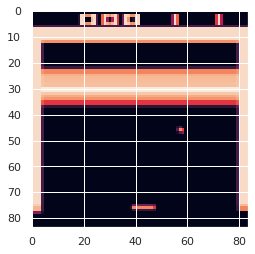

PRED D2:


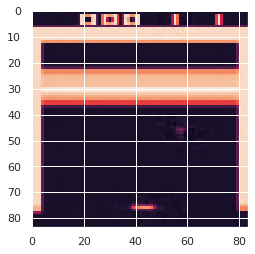

Batch 71, loss_ae_1 0.0016655117506161332, loss_ae_2 0.0027003190480172634
Batch 72, loss_ae_1 0.0018894729437306523, loss_ae_2 0.0029967769514769316
Batch 73, loss_ae_1 0.0016716595273464918, loss_ae_2 0.002710791537538171
Batch 74, loss_ae_1 0.002066876972094178, loss_ae_2 0.0032782757189124823
Batch 75, loss_ae_1 0.002065561944618821, loss_ae_2 0.003277992596849799
OBS:


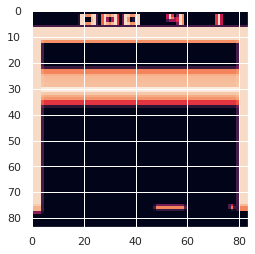

TARGET D1:


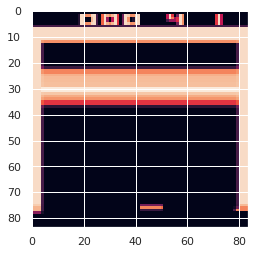

PRED D1:


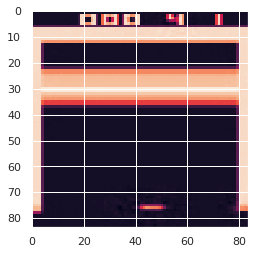

TARGET D2:


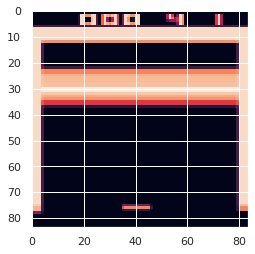

PRED D2:


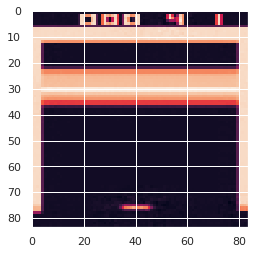

Batch 76, loss_ae_1 0.0015510737430304289, loss_ae_2 0.002573266625404358
Batch 77, loss_ae_1 0.0017255011480301619, loss_ae_2 0.002741398988291621
Batch 78, loss_ae_1 0.002063566353172064, loss_ae_2 0.0033305096440017223
Batch 79, loss_ae_1 0.0021677021868526936, loss_ae_2 0.003489359514787793
Batch 80, loss_ae_1 0.0021164363715797663, loss_ae_2 0.0034148595295846462
OBS:


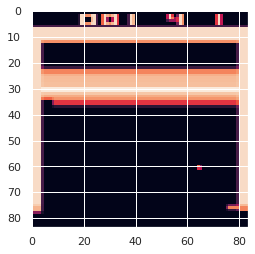

TARGET D1:


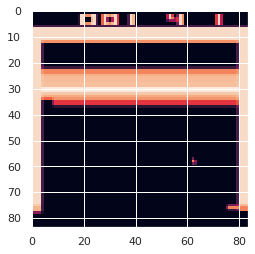

PRED D1:


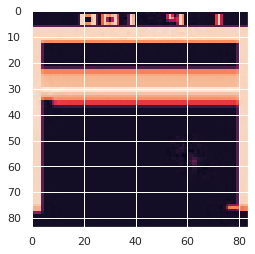

TARGET D2:


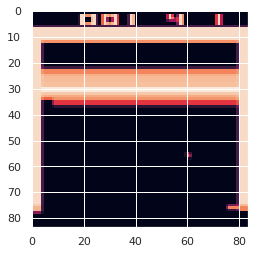

PRED D2:


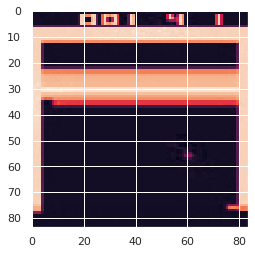

Batch 81, loss_ae_1 0.0018874803790822625, loss_ae_2 0.0029983450658619404
Batch 82, loss_ae_1 0.0014902439434081316, loss_ae_2 0.0024306436534971
Batch 83, loss_ae_1 0.0015540285967290401, loss_ae_2 0.002529650228098035
Batch 84, loss_ae_1 0.0017798132030293345, loss_ae_2 0.0028834170661866665
Batch 85, loss_ae_1 0.0019493396393954754, loss_ae_2 0.0031543835066258907
OBS:


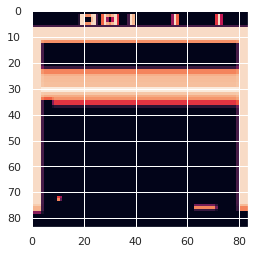

TARGET D1:


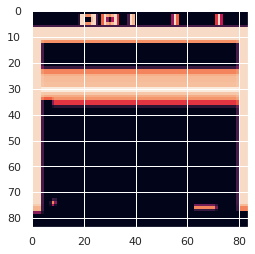

PRED D1:


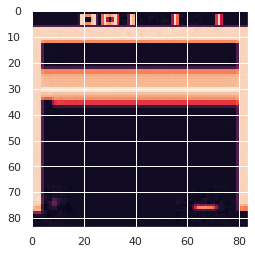

TARGET D2:


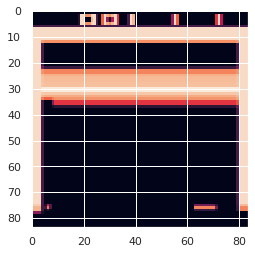

PRED D2:


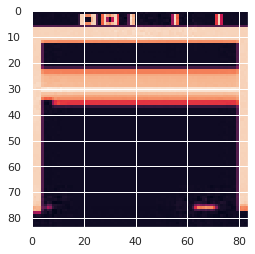

Batch 86, loss_ae_1 0.0017776933964341879, loss_ae_2 0.002882193075492978
Batch 87, loss_ae_1 0.001891038496978581, loss_ae_2 0.003005146747455001
Batch 88, loss_ae_1 0.0020608098711818457, loss_ae_2 0.0033226318191736937
Batch 89, loss_ae_1 0.002106353873386979, loss_ae_2 0.003340452676638961
Batch 90, loss_ae_1 0.0015478068962693214, loss_ae_2 0.002462592674419284
OBS:


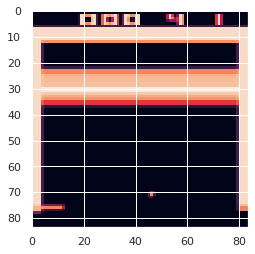

TARGET D1:


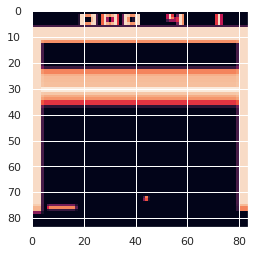

PRED D1:


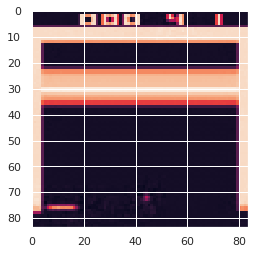

TARGET D2:


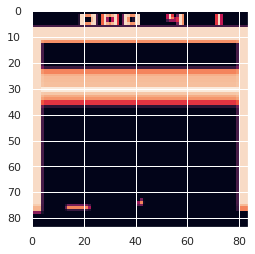

PRED D2:


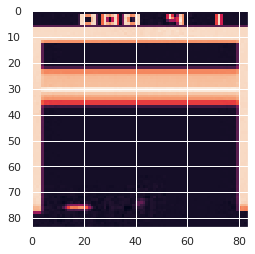

Batch 91, loss_ae_1 0.0019448742968961596, loss_ae_2 0.003091586986556649
Batch 92, loss_ae_1 0.0017769583500921726, loss_ae_2 0.002880421932786703
Batch 93, loss_ae_1 0.0016627246513962746, loss_ae_2 0.002703737933188677
Batch 94, loss_ae_1 0.0016581496456637979, loss_ae_2 0.0026392003055661917
Batch 95, loss_ae_1 0.0014937161467969418, loss_ae_2 0.0024351601023226976
OBS:


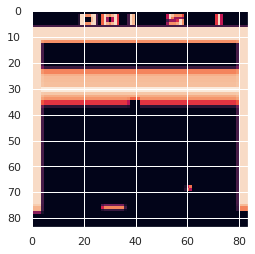

TARGET D1:


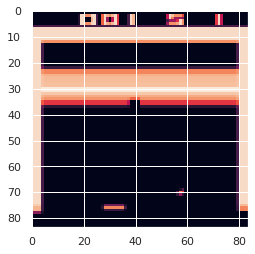

PRED D1:


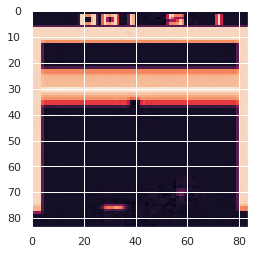

TARGET D2:


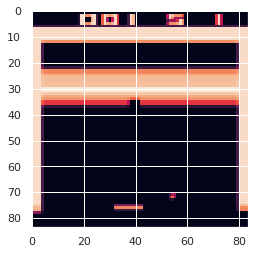

PRED D2:


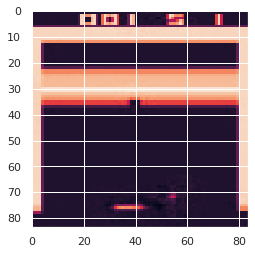

Batch 96, loss_ae_1 0.0019989660941064358, loss_ae_2 0.0032894546166062355
Batch 97, loss_ae_1 0.0020589083433151245, loss_ae_2 0.0033236746676266193
Batch 98, loss_ae_1 0.002056062687188387, loss_ae_2 0.003375142114236951
Batch 99, loss_ae_1 0.002337140031158924, loss_ae_2 0.0038055398035794497
Batch 100, loss_ae_1 0.0014248540392145514, loss_ae_2 0.0023281951434910297
OBS:


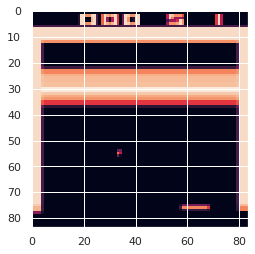

TARGET D1:


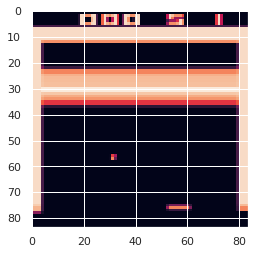

PRED D1:


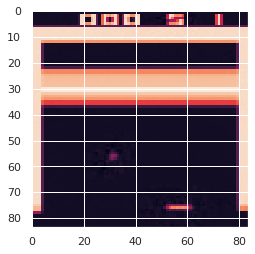

TARGET D2:


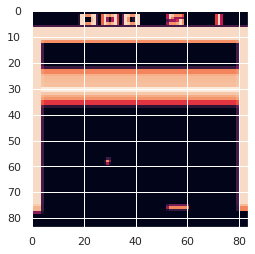

PRED D2:


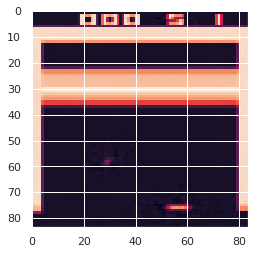

KeyboardInterrupt: ignored

In [11]:
FR = ROLLOUT_LENGTH*NENV

loss_history_ae_1 = []
loss_history_ae_2 = []
frames_loss_history_ae_1 = []
frames_loss_history_ae_2 = []

# Testing AE / pretraining
for ii in range(NUM_UPDATES):
    obs, obs_d1, obs_d2, logps, actions, values, rewards, infos = next(rgen)
    for jj in range(100):
        pred_ae_1, z1 = ae_delta_1(obs, actions.cpu().numpy().astype(int))
        citerion  = nn.MSELoss()
        loss_ae_1 = citerion(pred_ae_1, obs_d1)
        ae_optim_1.zero_grad()
        loss_ae_1.backward()
        nn.utils.clip_grad_norm_(ae_delta_1.parameters(), 0.5)
        ae_optim_1.step()

        pred_ae_2, z2 = ae_delta_2(obs, actions.cpu().numpy().astype(int))
        citerion  = nn.MSELoss()
        loss_ae_2 = citerion(pred_ae_2, obs_d2)
        ae_optim_2.zero_grad()
        loss_ae_2.backward()
        nn.utils.clip_grad_norm_(ae_delta_2.parameters(), 0.5)
        ae_optim_2.step()

        frames = (ii*100*FR) + (jj*FR)
        loss_history_ae_1.append(loss_ae_1.item())
        frames_loss_history_ae_1.append((frames, loss_ae_1.item()))
        loss_history_ae_2.append(loss_ae_2.item())
        frames_loss_history_ae_2.append((frames, loss_ae_2.item()))
        
    print(f'Batch {ii}, loss_ae_1 {loss_ae_1}, loss_ae_2 {loss_ae_2}')
    ae_1_scheduler.step(ii)
    ae_2_scheduler.step(ii)

    if ii % 5 == 0:
        print('OBS:')
        plt.imshow(obs.cpu().numpy()[500][0])
        plt.show()
        print('TARGET D1:')
        plt.imshow(obs_d1.cpu().numpy()[500][0])
        plt.show()
        print('PRED D1:')
        plt.imshow(pred_ae_1.detach().cpu().numpy()[500][0])
        plt.show()
        print('TARGET D2:')
        plt.imshow(obs_d2.cpu().numpy()[500][0])
        plt.show()
        print('PRED D2:')
        plt.imshow(pred_ae_2.detach().cpu().numpy()[500][0])
        plt.show()

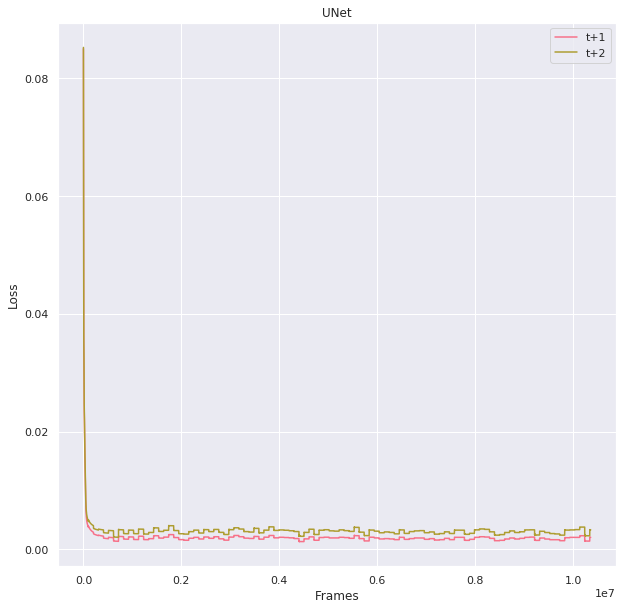

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Frames')
ax.set_ylabel('Loss')
ax.set_title('UNet')
clrs = sns.color_palette("husl", 5)

ax.plot(
    *zip(*frames_loss_history_ae_1),
    label='t+1', 
    c=clrs[0]
)
ax.plot(
    *zip(*frames_loss_history_ae_2),
    label='t+2', 
    c=clrs[1]
)

ax.legend(loc='upper right')

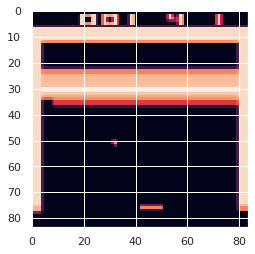

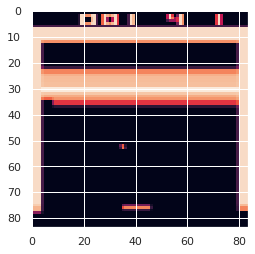

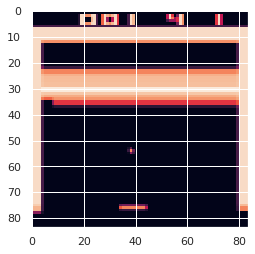

In [16]:
plt.imshow(obs.cpu().numpy()[750][0])
plt.show()
plt.imshow(obs.cpu().numpy()[758][0])
plt.show()
plt.imshow(obs.cpu().numpy()[766][0])
plt.show()

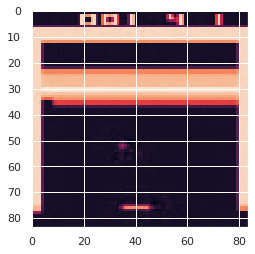

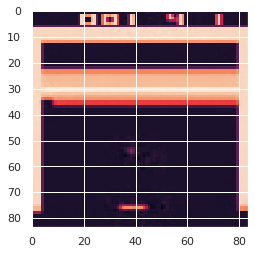

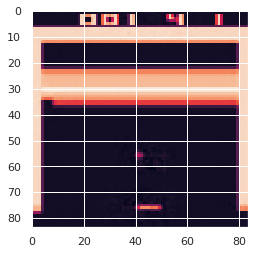

In [17]:
plt.imshow(pred_ae_1.detach().cpu().numpy()[750][0])
plt.show()
plt.imshow(pred_ae_1.detach().cpu().numpy()[758][0])
plt.show()
plt.imshow(pred_ae_1.detach().cpu().numpy()[766][0])
plt.show()

In [22]:
((z2[800].detach() - z1[808].detach())**2).mean()

tensor(0.1589, device='cuda:0')

In [21]:
(z2[800].detach() - z1[808].detach())

tensor([ 5.7548e-01,  7.5553e-01, -1.6651e-01,  3.2442e-01, -5.6900e-01,
        -8.6261e-02,  1.3277e-01, -4.7834e-01,  2.9193e-01,  3.0721e-03,
         3.8191e-01,  5.1281e-01,  3.1002e-01,  3.7226e-02, -6.8687e-01,
         1.4610e-01,  2.3227e-01, -3.0492e-01,  8.9140e-02, -2.5692e-01,
         8.8745e-02,  2.9631e-01, -4.8477e-01, -5.4794e-01, -1.6069e-01,
         4.4766e-01,  1.6763e-01,  1.7888e-01, -1.0300e-01, -1.6134e-02,
        -4.9001e-01,  9.0175e-02, -1.4093e-01,  2.5464e-01,  3.5717e-01,
         5.7507e-01, -2.3194e-01,  2.3444e-01, -4.1249e-01,  6.2216e-01,
         5.0273e-01, -7.9642e-01, -9.4984e-02,  3.5304e-01,  1.0792e-01,
        -4.2048e-01, -6.7684e-02,  4.9244e-01, -5.3131e-02, -4.7393e-01,
         1.0858e-01, -8.1039e-02,  9.0910e-01, -1.3124e-01, -1.5036e-01,
         3.9934e-02,  1.5143e-01, -2.9168e-01, -4.1435e-01,  3.0556e-01,
         6.3149e-01, -4.0900e-01, -2.2460e-01, -2.0952e-01, -1.5183e-01,
        -5.8540e-01, -4.3850e-01,  2.5535e-01, -3.1

In [0]:
T.save(ae_delta_1.state_dict(), 'ae1-unet-breakout.torch')
T.save(ae_delta_2.state_dict(), 'ae2-unet-breakout.torch')

In [0]:
from google.colab import files

files.download('ae1-unet-breakout.torch')
files.download('ae2-unet-breakout.torch')

In [32]:
import gym

e2 = gym.make(ENV_NAME)
e2.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

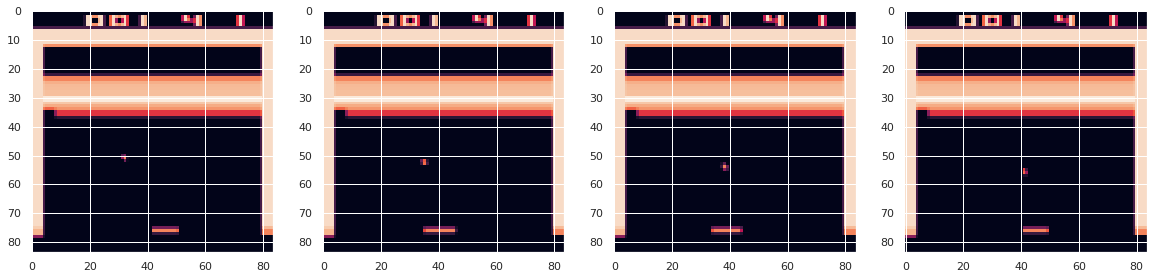

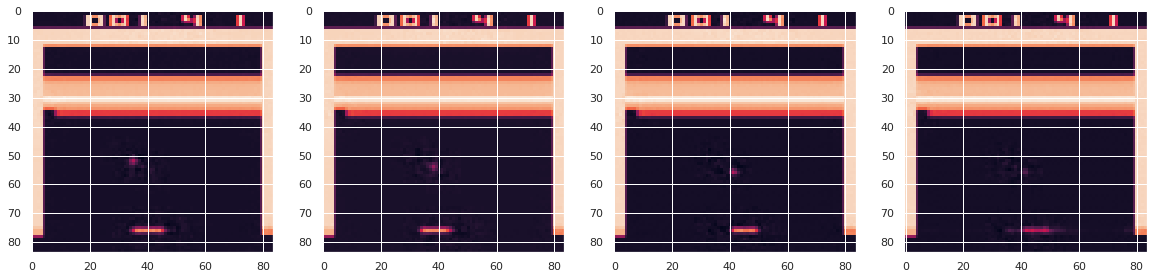

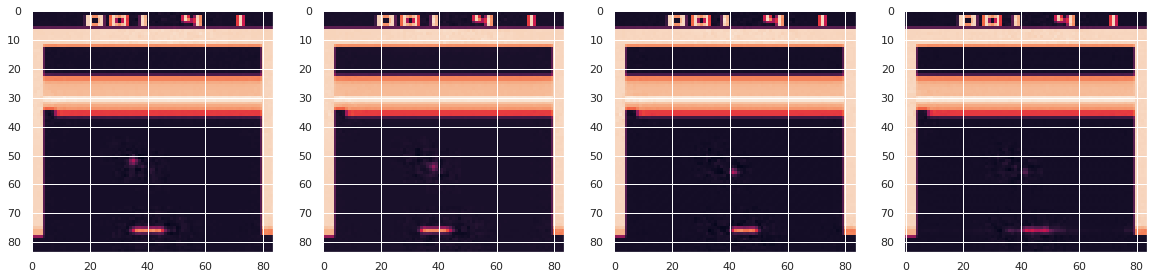

Should have left bais


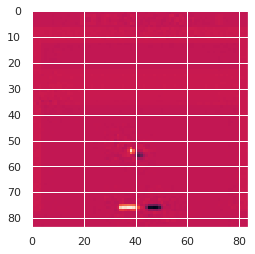

Should have right bais


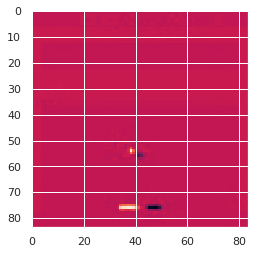

In [83]:
# Lets see whether our model has learned a self model

test_ob = obs[750]

fig, axs = plt.subplots(1, 4, figsize=(20,20))
im_ob = test_ob.cpu().numpy()
[a.imshow(im_ob[i]) for i, a in enumerate(axs)]
plt.show()

# # the paddle should stay stationary after taking action 0
# pred_tb, z_tb = ae_delta_2(test_ob.unsqueeze(0), [0])
# im_tb = pred_tb.detach().cpu().numpy()[0]
# fig, axs = plt.subplots(1, 4, figsize=(20,20))
# [a.imshow(im_tb[i]) for i, a in enumerate(axs)]
# plt.show()

# # the paddle should stay stationary after taking action 1
# pred_tb, z_tb = ae_delta_2(test_ob.unsqueeze(0), [1])
# im_tb = pred_tb.detach().cpu().numpy()[0]
# fig, axs = plt.subplots(1, 4, figsize=(20,20))
# [a.imshow(im_tb[i]) for i, a in enumerate(axs)]
# plt.show()

# the paddle should be a bit to the right after taking action 2
pred_tb, z_tb = ae_delta_1(test_ob.unsqueeze(0), [2])
im_tb = pred_tb.detach().cpu().numpy()[0]
fig, axs = plt.subplots(1, 4, figsize=(20,20))
[a.imshow(im_tb[i]) for i, a in enumerate(axs)]
plt.show()

# the paddle should be a bit to the left after taking action 3
pred_ta, z_ta = ae_delta_1(test_ob.unsqueeze(0), [3])
im_ta = pred_ta.detach().cpu().numpy()[0]
fig, axs = plt.subplots(1, 4, figsize=(20,20))
[a.imshow(im_ta[i]) for i, a in enumerate(axs)]
plt.show()


print('Should have left bais')
plt.imshow((im_ob-im_ta)[2])
plt.show()

print('Should have right bais')
plt.imshow((im_ob-im_tb)[2])
plt.show()


In [0]:
# it hasnt.

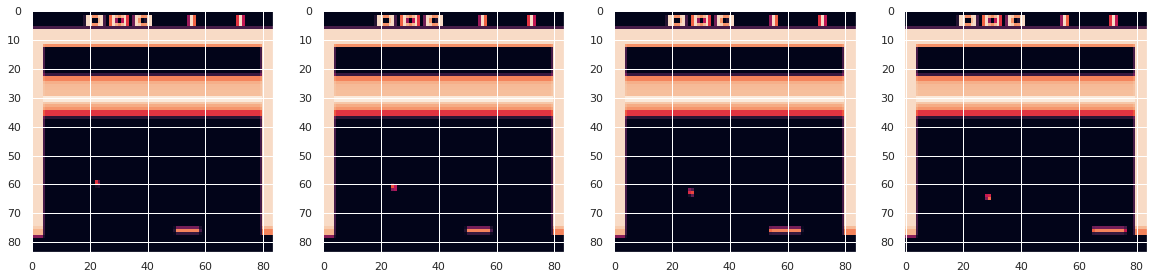

In [71]:
obz,_,_,_ = env.step([2]*8)
im_ob = obz[4]/255.

fig, axs = plt.subplots(1, 4, figsize=(20,20))
[a.imshow(im_ob[:,:,i]) for i, a in enumerate(axs)]
plt.show()